この notebook では、最大の時間発展 $t_K$ と、各時間 $t$ における適切な $n_{\text{step}}$ を求める。

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# Add the fourier_learning_ibm package to the path
# This is necessary only when running the notebook in the docker container
import sys, pprint

sys.path.append("/home/jovyan/fourier_learning_ibm/")
pprint.pprint(sys.path)

# This is necessary only when running the notebook in the docker container
%cd fourier_learning_ibm/

['/home/jovyan',
 '/opt/conda/lib/python311.zip',
 '/opt/conda/lib/python3.11',
 '/opt/conda/lib/python3.11/lib-dynload',
 '',
 '/opt/conda/lib/python3.11/site-packages',
 '/home/jovyan/fourier_learning_ibm/']
/home/jovyan/fourier_learning_ibm


In [3]:
import numpy as np
from numpy.linalg import qr
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import time
import networkx as nx
from heisenberg import (
    HeisenbergModel,
    get_graph,
    get_positions,
)
from setup import setup_backend
from heisenberg import HeisenbergModel, get_graph, get_positions
from qiskit import transpile
from qiskit.quantum_info.operators import Operator
from qiskit.quantum_info import (
    Statevector,
    state_fidelity,
)
import json

In [4]:
import warnings

warnings.filterwarnings("ignore")

### Config backend 

In [5]:
# state vector simulator
backend_qpu, backend_sim_noiseless, backend_sim_noisy = setup_backend(
    qpu_name="ibm_marrakesh"
)

Using backend QPU: <IBMBackend('ibm_marrakesh')>
Using backend noiseless simulator: AerSimulator('aer_simulator')

NoiseModel:
  Basis gates: ['cz', 'delay', 'for_loop', 'id', 'if_else', 'measure', 'reset', 'rz', 'switch_case', 'sx', 'x']
  Instructions with noise: ['sx', 'cz', 'measure', 'x', 'reset', 'id']
  Qubits with noise: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155

In [6]:
# # MPS simulator
# backend_qpu, backend_sim_noiseless, backend_sim_noisy = setup_backend(
#     qpu_name="ibm_marrakesh", method="matrix_product_state"
# )

In [7]:
# Config number of qubits
n_qubits = 4

## ノイズありシミュレーション

ランダムに複数個作ったハミルトニアンについて、ノイズありの積公式シミュレーションを行う。その後、複数ハミルトニアンについての平均 fidelity が閾値 xx 以上となる最大の $t$ を $t_K$ とする。

おさらいになるが、私たちはハミルトニアン $H$ の関数 $f(H)$ を求めたい。そこで、$f$ を $[-C, C]$ で定義される周期 $2C$ の関数と見てフーリエ級数近似する:
\begin{aligned}
f(x) &\simeq a_0 + \sum_{k=1}^K \left(a_k \cos \frac{k \pi x}{C}+b_k \sin \frac{k \pi x}{C}\right) \\
\therefore \operatorname{Tr}[f(H)\rho]
&\simeq a_0 + \sum_{k=1}^K \left( a_k \operatorname{Re}\left[\operatorname{Tr}\left[e^{-i t_k H} \rho\right]\right] + b_k \operatorname{Im}\left[\operatorname{Tr}\left[e^{-i t_k H} \rho\right]\right] \right) \\
&\qquad \qquad \left(t_k = \frac{k\pi}{C} \right) \\
\end{aligned}

上の式より特徴量の個数は、実部・虚部合わせて $2K+1$ である。またあらゆる (1 次元ハイゼンベルグ) ハミルトニアン $H$ について $C\ge\|H\|$ としたいので、
\begin{aligned}
C=3 \; \left( = 3 \sum_{i=0}^{n-2} |J_i| \ge \|H\| \right) 
\end{aligned}
とする。

In [8]:
# オリジナル

n_qubits = 4
n_samples = 5
# C = 3 * (n_qubits - 1)
# C = 3  # H が ||H|| <= 3 となるように正規化されているため
C = 5

if n_qubits == 4:
    n_steps = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
    max_time = 20.0
elif n_qubits == 8:
    n_steps = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
    max_time = 10.0
else:
    n_steps = [1, 2, 3, 4, 5, 6, 7, 8]
    max_time = 2.0

# t_k = k * pi / C
times = np.arange(0, max_time, np.pi / C)
print(f"times: {times}\n")
results = []
rng = np.random.default_rng(42)

# 保存用のファイルを初期化
with open(f"results/get_param/temp_progress.txt", "w") as f:
    f.write("")  # ファイルを空にする

for i in range(n_samples):
    # 途中経過を表示 + ファイルに保存
    progress_report = f"sample: {i}"
    print(progress_report)
    with open(
        f"results/get_param/temp_progress.txt", "a"
    ) as f:  # 使い回すので temp をつける
        f.write(progress_report + "\n")

    # -1 から 1 の一様乱数で Js を生成。その後 sum(|Js|) = 1 になるように正規化
    Js = rng.uniform(-1, 1, size=n_qubits - 1)
    Js /= np.sum(np.abs(Js))

    # ハイゼンベルグモデルを生成
    G = get_graph(n_qubits, Js)
    heisenberg = HeisenbergModel(n_qubits, G)

    for t in times:
        # initial state
        state_init = Statevector.from_label("0" * n_qubits)

        # Exact simulation (Non-Trotter)
        state_exact, U_exact = heisenberg.exact_simulation(t, phase=0)

        # Trotter simulation
        for n_step in n_steps:
            if n_step == 0:
                n_step = 1

            circuit = heisenberg.get_circuit(t, n_step, phase=0)
            circuit.remove_final_measurements()
            exec_circuit = transpile(circuit, backend_sim_noisy)
            exec_circuit.save_density_matrix()

            start = time.time()
            result = backend_sim_noisy.run(exec_circuit).result()
            state_trotter = result.data()["density_matrix"]
            sta_fidelity = state_fidelity(state_exact, state_trotter)
            end = time.time()
            elapsed_time = end - start

            # 途中経過を表示 + ファイルに保存
            progress_report = f"t: {t:.3f}, n_step: {n_step}, fidelity: {sta_fidelity:.3e}, elapsed_time: {elapsed_time:.3f}[s]\n"
            print(progress_report)
            with open(
                f"results/get_param/temp_progress.txt", "a"
            ) as f:  # 使い回すので temp をつける
                f.write(progress_report + "\n")

            results.append(
                {
                    "sample": i,
                    "t": t,
                    "n_step": n_step,
                    "sta_fidelity": sta_fidelity,
                }
            )

    print()

times: [ 0.          0.62831853  1.25663706  1.88495559  2.51327412  3.14159265
  3.76991118  4.39822972  5.02654825  5.65486678  6.28318531  6.91150384
  7.53982237  8.1681409   8.79645943  9.42477796 10.05309649 10.68141502
 11.30973355 11.93805208 12.56637061 13.19468915 13.82300768 14.45132621
 15.07964474 15.70796327 16.3362818  16.96460033 17.59291886 18.22123739
 18.84955592 19.47787445]

sample: 0
t: 0.000, n_step: 1, fidelity: 1.000e+00, elapsed_time: 1.533[s]

t: 0.000, n_step: 2, fidelity: 1.000e+00, elapsed_time: 1.303[s]

t: 0.000, n_step: 3, fidelity: 1.000e+00, elapsed_time: 1.287[s]

t: 0.000, n_step: 4, fidelity: 1.000e+00, elapsed_time: 1.034[s]

t: 0.000, n_step: 5, fidelity: 1.000e+00, elapsed_time: 1.453[s]

t: 0.000, n_step: 6, fidelity: 1.000e+00, elapsed_time: 1.255[s]

t: 0.000, n_step: 7, fidelity: 1.000e+00, elapsed_time: 1.245[s]

t: 0.000, n_step: 8, fidelity: 1.000e+00, elapsed_time: 1.252[s]

t: 0.000, n_step: 9, fidelity: 1.000e+00, elapsed_time: 1.310[s

In [ ]:
# state vector simulator での計算

n_qubits = 20
n_samples = 5
# C = 3 * (n_qubits - 1)
C = 3  # H が ||H|| <= 3 となるように正規化されているため

if n_qubits == 4:
    n_steps = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
    max_time = 20.0
elif n_qubits == 8:
    n_steps = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
    max_time = 10.0
else:
    n_steps = [1, 2, 3, 4, 5, 6, 7, 8]
    max_time = 2.0

# t_k = k * pi / C
times = np.arange(0, max_time, np.pi / C)
print(f"times: {times}\n")
results = []
rng = np.random.default_rng(42)

# 保存用のファイルを初期化
with open(f"results/get_param/temp_progress.txt", "w") as f:
    f.write("")  # ファイルを空にする

for i in range(n_samples):
    # 途中経過を表示 + ファイルに保存
    progress_report = f"sample: {i}"
    print(progress_report)
    with open(
        f"results/get_param/temp_progress.txt", "a"
    ) as f:  # 使い回すので temp をつける
        f.write(progress_report + "\n")

    # -1 から 1 の一様乱数で Js を生成。その後 sum(|Js|) = 1 になるように正規化
    Js = rng.uniform(-1, 1, size=n_qubits - 1)
    Js /= np.sum(np.abs(Js))

    # ハイゼンベルグモデルを生成
    G = get_graph(n_qubits, Js)
    heisenberg = HeisenbergModel(n_qubits, G)
    print("hoge")

    for t in times:
        # initial state
        # state_init = Statevector.from_label("0" * n_qubits)

        # Exact simulation (Non-Trotter)
        # state_exact, U_exact = heisenberg.exact_simulation(t, phase=0)

        # Trotter simulation
        for n_step in n_steps:
            if n_step == 0:
                n_step = 1

            circuit = heisenberg.get_circuit(t, n_step, phase=0)
            # circuit.save_matrix_product_state()
            circuit.save_statevector()
            exec_circuit = transpile(circuit, backend_sim_noisy)

            start = time.time()
            result = backend_sim_noisy.run(exec_circuit).result()

            state_trotter = result.data()["statevector"]
            # sta_fidelity = state_fidelity(state_exact, state_trotter)
            end = time.time()
            elapsed_time = end - start

            # 途中経過を表示 + ファイルに保存
            # progress_report = f"t: {t:.3f}, n_step: {n_step}, fidelity: {sta_fidelity:.3e}, elapsed_time: {elapsed_time:.3f}[s]\n"
            progress_report = (
                f"t: {t:.3f}, n_step: {n_step}, elapsed_time: {elapsed_time:.3f}[s]\n"
            )
            print(progress_report)
            with open(
                f"results/get_param/temp_progress.txt", "a"
            ) as f:  # 使い回すので temp をつける
                f.write(progress_report + "\n")

            results.append(
                {
                    "sample": i,
                    "t": t,
                    "n_step": n_step,
                    # "sta_fidelity": sta_fidelity,
                }
            )

    print()

times: [0.         1.04719755]

sample: 0
hoge


In [ ]:
# MPS での計算

n_qubits = 50
n_samples = 5
C = 3 * (n_qubits - 1)
# C = 3  # H が ||H|| <= 3 となるように正規化されているため

if n_qubits == 4:
    n_steps = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
    max_time = 20.0
elif n_qubits == 8:
    n_steps = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
    max_time = 10.0
else:
    n_steps = [1, 2, 3, 4, 5, 6, 7, 8]
    max_time = 2.0

# t_k = k * pi / C
times = np.arange(0, max_time, np.pi / C)
print(f"times: {times}\n")
results = []
rng = np.random.default_rng(42)

# 保存用のファイルを初期化
with open(f"results/get_param/temp_progress.txt", "w") as f:
    f.write("")  # ファイルを空にする

for i in range(n_samples):
    # 途中経過を表示 + ファイルに保存
    progress_report = f"sample: {i}"
    print(progress_report)
    with open(
        f"results/get_param/temp_progress.txt", "a"
    ) as f:  # 使い回すので temp をつける
        f.write(progress_report + "\n")

    # -1 から 1 の一様乱数で Js を生成。その後 sum(|Js|) = 1 になるように正規化
    Js = rng.uniform(-1, 1, size=n_qubits - 1)
    Js /= np.sum(np.abs(Js))

    # ハイゼンベルグモデルを生成
    G = get_graph(n_qubits, Js)
    heisenberg = HeisenbergModel(n_qubits, G)

    for t in times:
        # initial state
        # state_init = Statevector.from_label("0" * n_qubits)

        # Exact simulation (Non-Trotter)
        # state_exact, U_exact = heisenberg.exact_simulation(t, phase=0)

        # Trotter simulation
        for n_step in n_steps:
            if n_step == 0:
                n_step = 1

            circuit = heisenberg.get_circuit(t, n_step, phase=0)
            circuit.save_matrix_product_state()
            exec_circuit = transpile(circuit, backend_sim_noisy)

            start = time.time()
            result = backend_sim_noisy.run(exec_circuit).result()

            state_trotter = result.data()["matrix_product_state"]
            # sta_fidelity = state_fidelity(state_exact, state_trotter)
            end = time.time()
            elapsed_time = end - start

            # 途中経過を表示 + ファイルに保存
            # progress_report = f"t: {t:.3f}, n_step: {n_step}, fidelity: {sta_fidelity:.3e}, elapsed_time: {elapsed_time:.3f}[s]\n"
            progress_report = (
                f"t: {t:.3f}, n_step: {n_step}, elapsed_time: {elapsed_time:.3f}[s]\n"
            )
            print(progress_report)
            with open(
                f"results/get_param/temp_progress.txt", "a"
            ) as f:  # 使い回すので temp をつける
                f.write(progress_report + "\n")

            results.append(
                {
                    "sample": i,
                    "t": t,
                    "n_step": n_step,
                    # "sta_fidelity": sta_fidelity,
                }
            )

    print()

times: [0.         1.04719755]

sample: 0
t: 0.000, n_step: 1, elapsed_time: 1.533[s]

t: 0.000, n_step: 2, elapsed_time: 1.089[s]

t: 0.000, n_step: 3, elapsed_time: 1.455[s]

t: 0.000, n_step: 4, elapsed_time: 1.280[s]

t: 0.000, n_step: 5, elapsed_time: 1.273[s]

t: 0.000, n_step: 6, elapsed_time: 1.451[s]

t: 0.000, n_step: 7, elapsed_time: 1.289[s]

t: 0.000, n_step: 8, elapsed_time: 1.480[s]

t: 1.047, n_step: 1, elapsed_time: 30.686[s]

t: 1.047, n_step: 2, elapsed_time: 63.671[s]

t: 1.047, n_step: 3, elapsed_time: 99.532[s]

t: 1.047, n_step: 4, elapsed_time: 151.861[s]

t: 1.047, n_step: 5, elapsed_time: 215.675[s]



In [9]:
df = pd.DataFrame(results)
# t と sample と n_step ごとに sta_fidelity をグループ化
df_grouped = df.groupby(["t", "sample", "n_step"]).agg({"sta_fidelity": "mean"})
df_grouped = df_grouped.reset_index()
display(df_grouped)

,t,sample,n_step,sta_fidelity
0,0.000000,0,1,1.000000
1,0.000000,0,2,1.000000
2,0.000000,0,3,1.000000
3,0.000000,0,4,1.000000
4,0.000000,0,5,1.000000
...,...,...,...,...
3195,19.477874,4,16,0.369522
3196,19.477874,4,17,0.387888
3197,19.477874,4,18,0.399677
3198,19.477874,4,19,0.406376


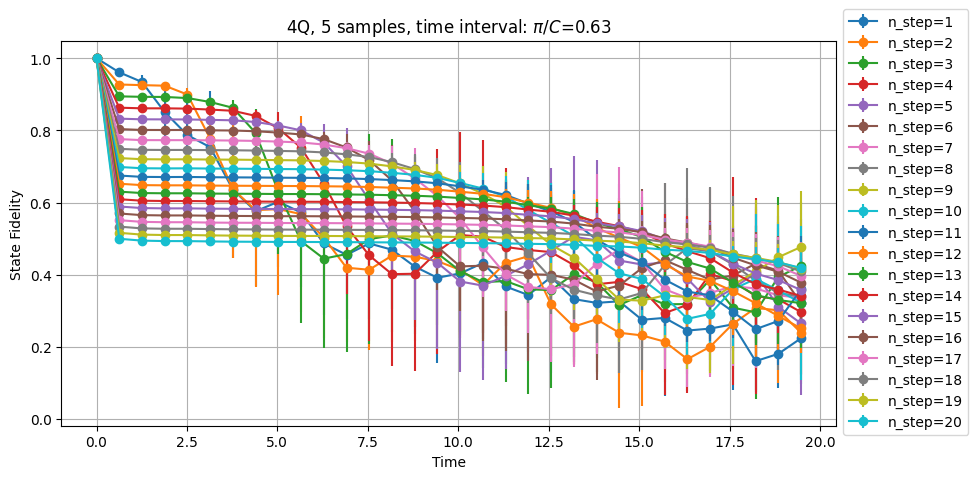

In [10]:
# sta_fidelity の sample に対する平均と分散を計算
df_grouped_mean = df_grouped.groupby(["t", "n_step"]).agg({"sta_fidelity": "mean"})
df_grouped_mean = df_grouped_mean.reset_index()
df_grouped_std = df_grouped.groupby(["t", "n_step"]).agg({"sta_fidelity": "std"})
df_grouped_std = df_grouped_std.reset_index()

# plot
plt.figure(figsize=(10, 5))
for n_step in df_grouped["n_step"].unique():
    df_tmp = df_grouped_mean[df_grouped_mean["n_step"] == n_step]
    plt.errorbar(
        df_tmp["t"],
        df_tmp["sta_fidelity"],
        yerr=df_grouped_std[df_grouped_std["n_step"] == n_step]["sta_fidelity"],
        label=f"n_step={n_step}",
        marker="o",
    )
plt.xlabel("Time")
plt.ylabel("State Fidelity")
plt.legend(bbox_to_anchor=(1, 1.1), loc="upper left")
plt.grid()
plt.title(rf"{n_qubits}Q, {n_samples} samples, time interval: $\pi/C$={np.pi/C:.2f}")
plt.savefig(f"results/get_param/{n_qubits}Q/fidelity_vs_time_rough.pdf")
plt.show()

In [11]:
threshold = 0.60

# df_grouped_mean の sta_fidelity が、いずれの n_step でも threshold を超える最大の time を取得
max_time = df_grouped_mean[df_grouped_mean["sta_fidelity"] > threshold]["t"].max()
print(f"max_time (t_K): {max_time:.2f}")

# max_time 以下の t のみに絞る
df_grouped_mean_reduced = df_grouped_mean[df_grouped_mean["t"] <= max_time]
df_grouped_std_reduced = df_grouped_std[df_grouped_std["t"] <= max_time]

# 絞った各 t において、sta_fidelity の平均が最大となる n_step を取得
df_max_n_step = df_grouped_mean_reduced.loc[
    df_grouped_mean_reduced.groupby("t")["sta_fidelity"].idxmax(),
    ["t", "n_step", "sta_fidelity"],
]
df_max_n_step.reset_index(drop=True, inplace=True)

print(
    f"number of time points: {len(df_max_n_step)}, so K = {len(df_max_n_step) - 1} (except for t=0)"
)
display(df_max_n_step)

# json に保存 (orient="records" で行ごとに保存)
df_max_n_step.to_json(
    f"results/get_param/{n_qubits}Q/threshold{threshold:.2f}/optimal_n_step.json",
    orient="records",
    indent=4,
)

max_time (t_K): 11.31
number of time points: 19, so K = 18 (except for t=0)


,t,n_step,sta_fidelity
0,0.000000,1,1.000000
1,0.628319,1,0.960905
2,1.256637,1,0.934116
3,1.884956,2,0.923847
4,2.513274,2,0.899309
5,3.141593,3,0.878686
6,3.769911,3,0.862589
7,4.398230,4,0.840110
8,5.026548,5,0.813450
9,5.654867,5,0.800024


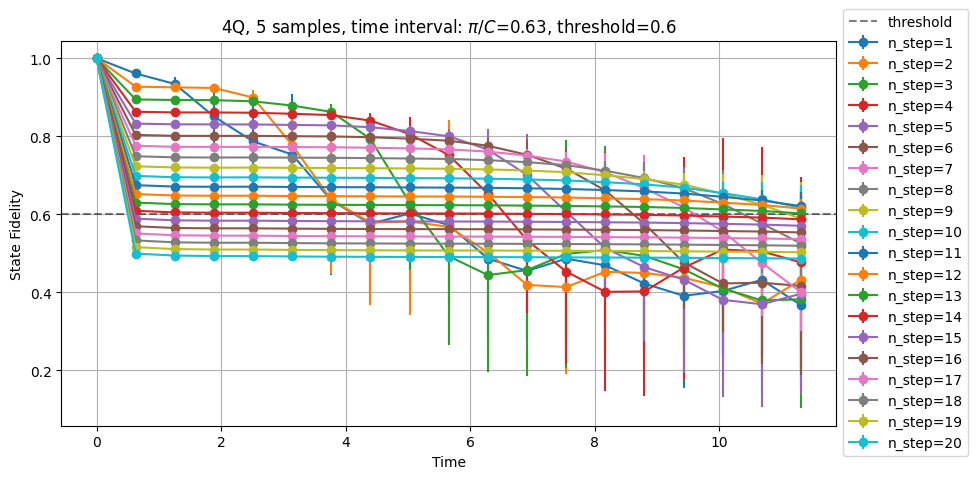

In [12]:
# plot
plt.figure(figsize=(10, 5))
for n_step in df_grouped_mean_reduced["n_step"].unique():
    df_tmp = df_grouped_mean_reduced[df_grouped_mean_reduced["n_step"] == n_step]
    plt.errorbar(
        df_tmp["t"],
        df_tmp["sta_fidelity"],
        yerr=df_grouped_std_reduced[df_grouped_std_reduced["n_step"] == n_step][
            "sta_fidelity"
        ],
        label=f"n_step={n_step}",
        marker="o",
    )
plt.xlabel("Time")
plt.ylabel("State Fidelity")
plt.axhline(
    y=threshold, linestyle="dashed", label="threshold", color="black", alpha=0.5
)
plt.legend(bbox_to_anchor=(1, 1.1), loc="upper left")
plt.grid()
plt.title(
    rf"{n_qubits}Q, {n_samples} samples, time interval: $\pi/C$={np.pi/C:.2f}, threshold={threshold}"
)
plt.savefig(
    f"results/get_param/{n_qubits}Q/threshold{threshold:.2f}/fidelity_vs_time_detail.pdf"
)
plt.show()